In [135]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [136]:
from Lo_r import LogisticRegression

In [183]:
def data_preprocessing(df):
    df['sex'] = df['sex'].apply(lambda s: (s=='Male' and 1) or (s=='Female' and 2))

    df['race'] = df['race'].apply(lambda r: (r=='African-American' and 1) or (r=='Asian' and 2) 
                                or (r=='Caucasian' and 3) or (r=='Hispanic' and 4) 
                                or (r=='Native American' and 5) or (r=='Other' and 6))

    df['c_charge_degree'] = df['c_charge_degree'].apply(lambda c: (c=='F' and 1) or (c=='M' and 2))
    
    df.drop(['race', 'c_charge_degree'], axis=1, inplace=True)
    
    X = df.drop('two_year_recid', axis=1)
    y = df['two_year_recid']
    
    std = StandardScaler()
    for col in X.columns:
        X[col] = std.fit_transform(X[col].to_numpy().reshape(-1, 1))
    
    X['sex'] = X['sex'].apply(lambda s: -s)
    X['age'] = X['age'].apply(lambda s: -s)
    
    return df, X, y

In [184]:
df_train = pd.read_json('./compas_data/train.json', lines=True)
df_dev = pd.read_json('./compas_data/dev.json', lines=True)
df_train

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid
0,Male,38,African-American,1,1,0,9,F,1
1,Male,51,Caucasian,0,0,0,4,M,0
2,Female,38,Hispanic,0,0,0,0,F,0
3,Male,42,Caucasian,0,0,0,0,M,0
4,Male,33,African-American,0,0,0,1,F,1
...,...,...,...,...,...,...,...,...,...
5044,Male,33,African-American,0,0,0,3,F,1
5045,Male,24,Hispanic,0,0,0,0,F,1
5046,Male,57,African-American,0,0,0,0,F,0
5047,Male,33,Caucasian,0,0,0,0,F,0


In [185]:
df_train.isna().sum()

sex                0
age                0
race               0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
two_year_recid     0
dtype: int64

In [186]:
df_train, X_train, y_train = data_preprocessing(df_train)
df_dev, X_dev, y_dev = data_preprocessing(df_dev)

<Axes: >

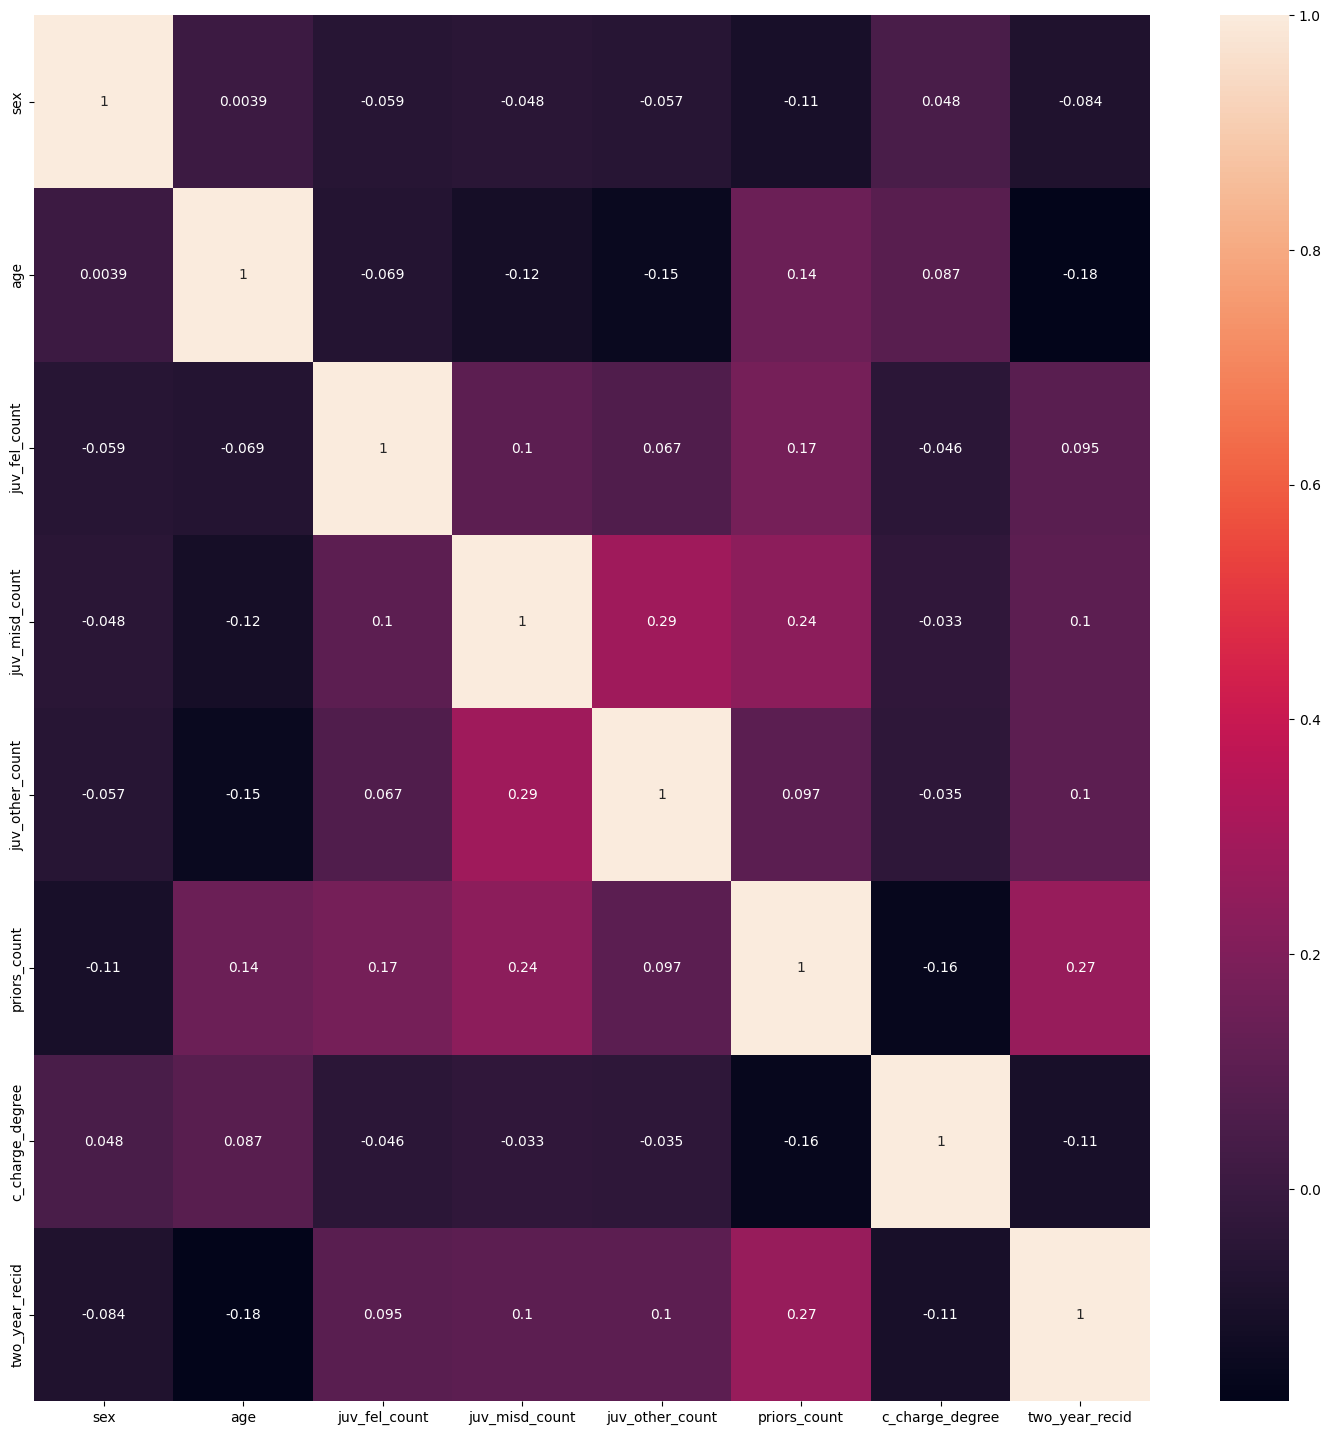

In [187]:
df_corr = df_train.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(df_corr, annot=True)
# f, ax = plt.subplots(figsize=(18, 18))

# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# heatmap = sns.heatmap(df_corr, cmap=cmap, center=0.0, vmax=1, linewidths=1, ax=ax)

In [188]:
def hyperparameter_tuning(X_train, y_train, X_dev, y_dev, param_grid):
    result = pd.DataFrame(columns=['param', 'f1_score', 'time'])
    for l in param_grid['learning_rate']:
        for m in param_grid['max_iter']:
            for f in param_grid['fit_intercept']:
                start = time.time()
                model = LogisticRegression(learning_rate=l, max_iter=m, fit_intercept=f)
                model.train_logistic_regression(X_train, y_train)
                end = time.time()
                y_pred = model.predict(X_dev)
                result.loc[len(result.index)] = [[l, m, f], f1_score(y_dev, y_pred), end-start]
                
    print(result)
    best_param = result.iloc[result['f1_score'].idxmax(), 0]        
    return best_param

In [189]:
param_grid = {'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.2], 'max_iter' : [200], 'fit_intercept' : [False]}

param = hyperparameter_tuning(X_train, y_train, X_dev, y_dev, param_grid)

                 param  f1_score       time
0  [0.001, 200, False]  0.643533  31.462263
1  [0.005, 200, False]  0.638365   5.972429
2   [0.01, 200, False]  0.638365   4.327808
3   [0.05, 200, False]  0.646059   3.935348
4    [0.1, 200, False]  0.639871   3.878603
5    [0.2, 200, False]  0.617496   3.921926


In [190]:
param

[0.05, 200, False]

In [191]:
model = LogisticRegression(param[0], param[1], param[2])
model.train_logistic_regression(X_train, y_train)

In [192]:
y_pred = model.predict(X_dev)
f1_score(y_dev, y_pred)

0.6460587326120556